In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
df = pd.read_csv("C:/Users/Po/OneDrive/Masaüstü/Cookie_Cats/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
## Explatory Data Analysis ##

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Nunique #####################")
    print(dataframe.nunique())
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T)

check_df(df)


##################### Shape #####################
(90189, 5)
##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
##################### Nunique #####################
userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64
##################### Head #####################
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
##################### Tail #####################
        userid  version  sum_gamerounds  retention_1  retention_7
90184  9999441  gate_40            

In [4]:
# A/B Groups & Target Summary Stats
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


In [5]:
# Summary Stats: sum_gamerounds
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


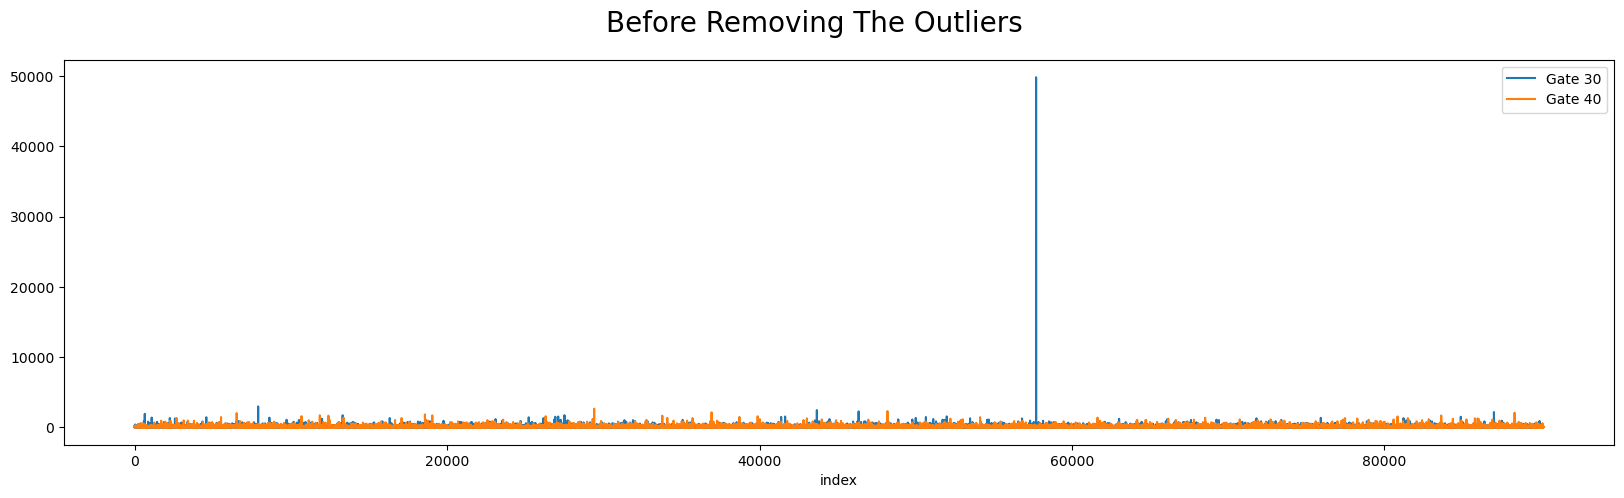

In [6]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Outliers", fontsize = 20);

In [7]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [8]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [9]:
replace_with_thresholds(df, "sum_gamerounds")

In [10]:
df['sum_gamerounds'].describe()

count   90189.0000
mean       51.1092
std        99.3123
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max      1232.5000
Name: sum_gamerounds, dtype: float64

In [11]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,51.1534,98.8021,1232.5000
gate_40,45489,16.0000,51.0658,99.8121,1232.5000


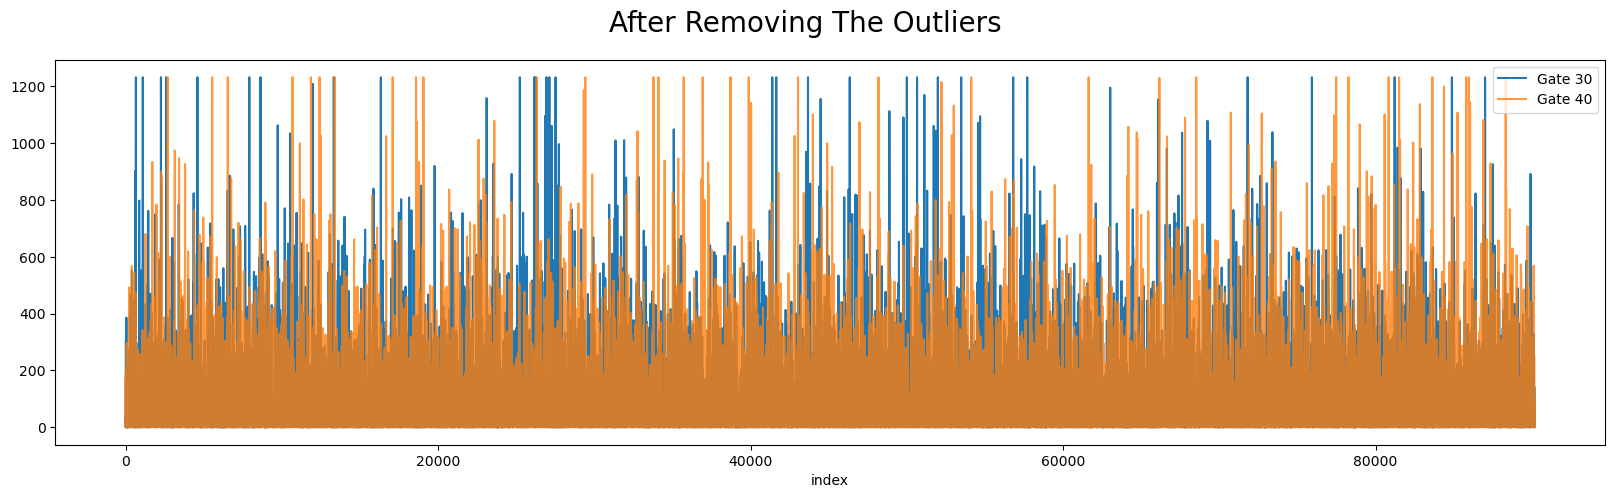

In [12]:
df[(df.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Outliers", fontsize = 20);

In [13]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0.0000       3994
1.0000       5538
2.0000       4606
3.0000       3958
4.0000       3629
             ... 
1200.0000       1
1209.0000       1
1215.0000       1
1230.0000       1
1232.5000      61
Name: userid, Length: 886, dtype: int64

Text(0.5, 0, '# Game rounds')

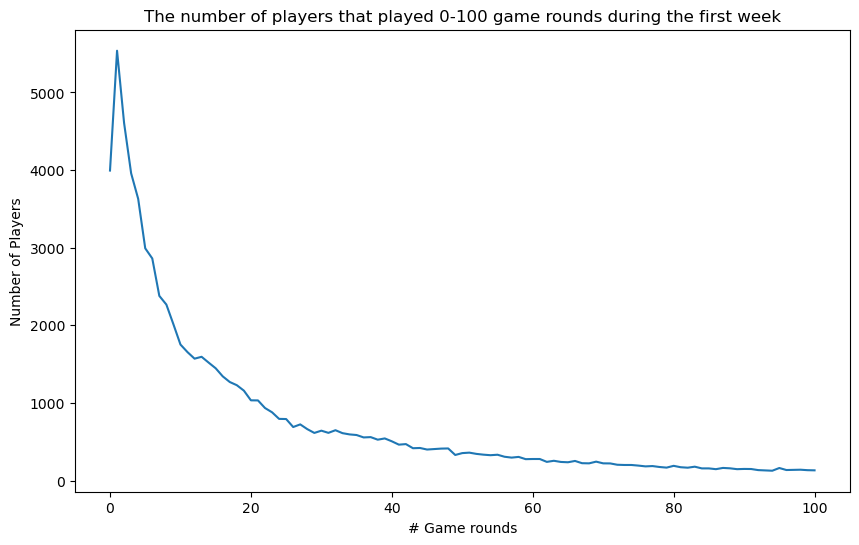

In [14]:
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

In [15]:
# How many users reached gate 30 & gate 40 levels?
df.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30.0000    642
40.0000    505
Name: userid, dtype: int64

In [16]:
# A/B Groups & Target Summary Stats
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,51.1534,98.8021,1232.5000
gate_40,45489,16.0000,51.0658,99.8121,1232.5000


In [17]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50036,73408,0.5548,0.8139
True,40153,16781,0.4452,0.1861


In [18]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std       max
version retention_1                                          
gate_30 False        24666  6.0000 16.4084  37.3394 1232.5000
        True         20034 48.0000 93.9317 129.4150 1232.5000
gate_40 False        25370  6.0000 16.3401  35.9144 1232.5000
        True         20119 49.0000 94.8548 132.1399 1232.5000

In [19]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std       max
version retention_7                                            
gate_30 False        36198  11.0000  25.7965  43.3162  981.0000
        True          8502 105.0000 159.1127 170.1326 1232.5000
gate_40 False        37210  11.0000  25.8185  42.7478 1232.5000
        True          8279 111.0000 164.5397 175.4627 1232.5000

In [20]:
df["Retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std       max
version Retention                                            
gate_30 0          38024  12.0000  28.1019  48.4125 1232.5000
        1           6676 127.0000 182.4460 178.1907 1232.5000
gate_40 0          38983  12.0000  28.0670  47.4933 1232.5000
        1           6506 133.0000 188.8710 184.3508 1232.5000

In [21]:
df["version"] = df["version"].replace({"gate_30": "A", "gate_40": "B"})


In [22]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,A,3.0000,False,False,0
1,337,A,38.0000,True,False,0
2,377,B,165.0000,True,False,0
3,483,B,1.0000,False,False,0
4,488,B,179.0000,True,True,1


In [23]:
group_A = df[df["version"] == "A"]["sum_gamerounds"]
group_B = df[df["version"] == "B"]["sum_gamerounds"]

In [24]:
test_stat, p_value = shapiro(group_A)
print("Test Stat = %.4f, p-value = %.4f" %(test_stat,p_value))

Test Stat = 0.5104, p-value = 0.0000


In [25]:
test_stat, p_value = shapiro(group_B)
print("Test Stat = %.4f, p-value = %.4f" %(test_stat,p_value))

Test Stat = 0.5044, p-value = 0.0000


In [26]:
test_stat, p_value = mannwhitneyu(group_A,group_B)
print("Test Stat = %.4f, p-value = %.4f" %(test_stat,p_value))

Test Stat = 1024331275.0000, p-value = 0.0502


In [27]:
df.groupby("version").retention_1.mean(), df.groupby("version").retention_7.mean()


(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)